In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows=10)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

<h1>Introduction</h1>

Understanding which types of players are most likely to contribute large amounts of data through extended gameplay can help optimize recruitment efforts for research or community-building purposes. The broad question this analysis seeks to address is: "Which kinds of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts?” To narrow this down, the specific question explored is: "Can player characteristics (experience, gender and age) predict the total number of hours played (played_hours) on the Minecraft server?"
The response variable of interest is played_hours, which quantifies the total time each player has spent on the server. The explanatory variables include:

- experience: a categorical variable representing the player's gaming experience level ( Amateur, Pro, Veteran)
- gender: a categorical variable with gender identities
- Age: a numerical variable indicating the player’s age

The goal is to use these characteristics to predict server engagement and identify which traits are associated with longer playtime. These variables will help determine whether certain player types, such as those with more experience or specific age groups, are more likely to spend longer hours on the server, thus contributing a larger amount of data. To answer this, the dataset used consists of 196 observations with 7 columns including player experience, gender, age, and playtime, as well as anonymized identifiers. The dataset was provided by Pacific Laboratory for Artificial Intelligence (PLAI) based on their computer program PLAICraft which consists of a virtual world like MineCraft. The data was sourced from a publicly available CSV on GitHub. We cleaned and wrangled the data, explored key variables through visual summaries, and finally applied a machine learning model, k-Nearest Neighbors regression, to evaluate whether player traits can reliably predict engagement time.


<h1> Methods and Results </h1>

<h4>Data Loading</h4>

The dataset was loaded using the read_csv() function from the tidyverse package from a raw data page on Github. This revealed 196 rows and 7 columns with variables of different types: character (chr), double (dbl), and logical (lgl).


In [2]:
player_data <- read_csv("https://raw.githubusercontent.com/AndrewH-dsci/DSCI-Group-Project/fa0dd401ba3e001aec7ea300254d95ecdc33d150/players.csv", show_col_types=FALSE)

<h4>Data Wrangling</h4>

To prepare the data for modeling:
- Categorical variables experience and gender were converted to factors.
- These were recorded into numeric values for model compatibility
- Players with missing age data and the 4 extreme outliers with 150+ hours playtime are filtered out 

In [3]:
wrangled_data<-player_data|>
    mutate(experience=as.factor(experience), gender=as.factor(gender))|>
    mutate(experience_numeric=recode(
                        experience, 
                             "Amateur"=1, 
                             "Beginner"=2, 
                             "Regular"=3, 
                             "Veteran"=4, 
                             "Pro"=5
                                     ),
            gender_numeric=recode(
                        gender, 
                             "Male"=1, 
                             "Female"=2, 
                             "Non-binary"=3, 
                             "Prefer not to say"=4, 
                             "Two-Spirited"=5, 
                             "Agender"=6,
                             "Other"=7
                                )
          )|>
    select(experience_numeric, gender_numeric)|>
    bind_cols(player_data)|>
    filter(Age!="NA")|>
    select(experience, experience_numeric, gender, gender_numeric, Age, played_hours)|>
    filter(played_hours<=100)|>
    mutate(experience=as.factor(experience), gender=as.factor(gender))

wrangled_data

experience,experience_numeric,gender,gender_numeric,Age,played_hours
<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
Pro,5,Male,1,9,30.3
Veteran,4,Male,1,17,3.8
Veteran,4,Male,1,17,0.0
Amateur,1,Female,2,21,0.7
Regular,3,Male,1,21,0.1
⋮,⋮,⋮,⋮,⋮,⋮
Amateur,1,Male,1,20,0.0
Amateur,1,Female,2,17,0.0
Veteran,4,Male,1,22,0.3


<h4>Dataset Summary</h4>

Figure 1. Gender Distribution of Players

This summary showed that the majority of players identified as Male (124), followed by Female (37), with smaller counts across other categories including Non-binary, Two-Spirited, and Prefer not to say.

In [4]:
gender_counts<-player_data|>
    group_by(gender)|>
    summarize(count=n())|>
    arrange(desc(count))
gender_counts

gender,count
<chr>,<int>
Male,124
Female,37
Non-binary,15
Prefer not to say,11
Two-Spirited,6
Agender,2
Other,1


Figure 2. Experience Levels of Players

Most players identified as Amateur (63), with the remaining distributed across Veteran, Beginner, and Regular levels with very few (14) Pro's.

In [5]:

experience_counts<-player_data|>
    group_by(experience)|>
    summarize(count=n())
experience_counts

experience,count
<chr>,<int>
Amateur,63
Beginner,35
Pro,14
Regular,36
Veteran,48


Figure 3. Summary Statistics of Age
|Mean|Median|Standard Deviation|
|------------|------------|------------|
| 20.574|19|6.224|


In [6]:
mean(wrangled_data$Age)
median(wrangled_data$Age)
sd(wrangled_data$Age)

[1] 20.57368

[1] 19

[1] 6.224405

<h4>Exploratory Data Visualization</h4>

These three following visualizations show the distribution of played hours and visualize the predictors corrlation with the output variable playtime (gender as a predictor being excluded is discussed later and is not visualized).

Figure 4: Playtime Distribution

This distribution is extremely right skewed as most players are between 0 and 4 hours of playtime with few players having high playtimes 

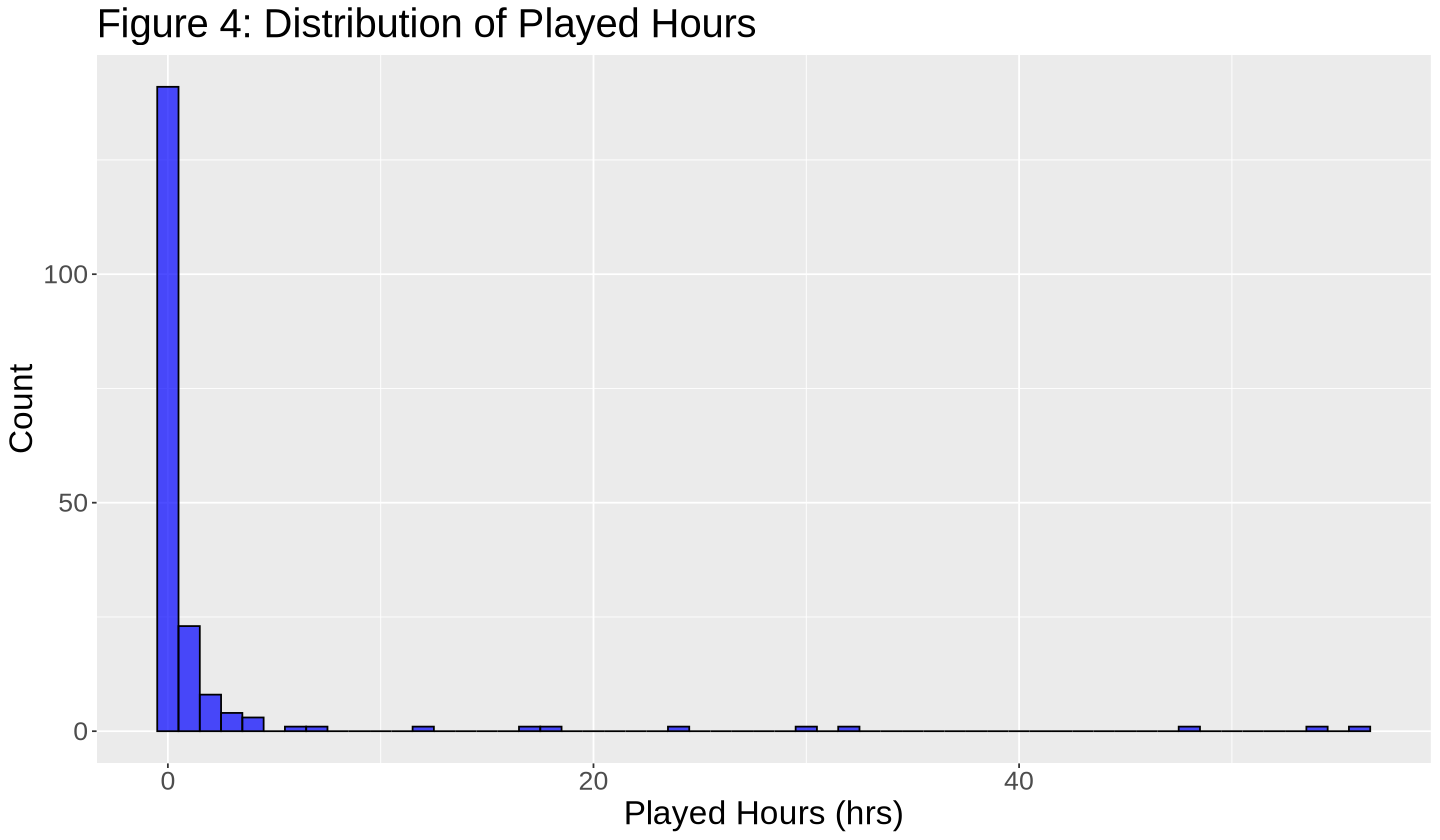

In [7]:
options(repr.plot.width=12, repr.plot.height=7)
played_hours_distribution<-ggplot(wrangled_data, aes(x=played_hours))+
    geom_histogram(binwidth=1, fill="blue", color="black", alpha=0.7)+
    labs(title="Figure 4: Distribution of Played Hours", x="Played Hours (hrs)", y="Count")+
    theme(text=element_text(size=20))
played_hours_distribution

Figure 5: Player Age and Playtime

Many players appear to be concentrated around the ages of 16 to 24 within a wide range between 8 and 50. 

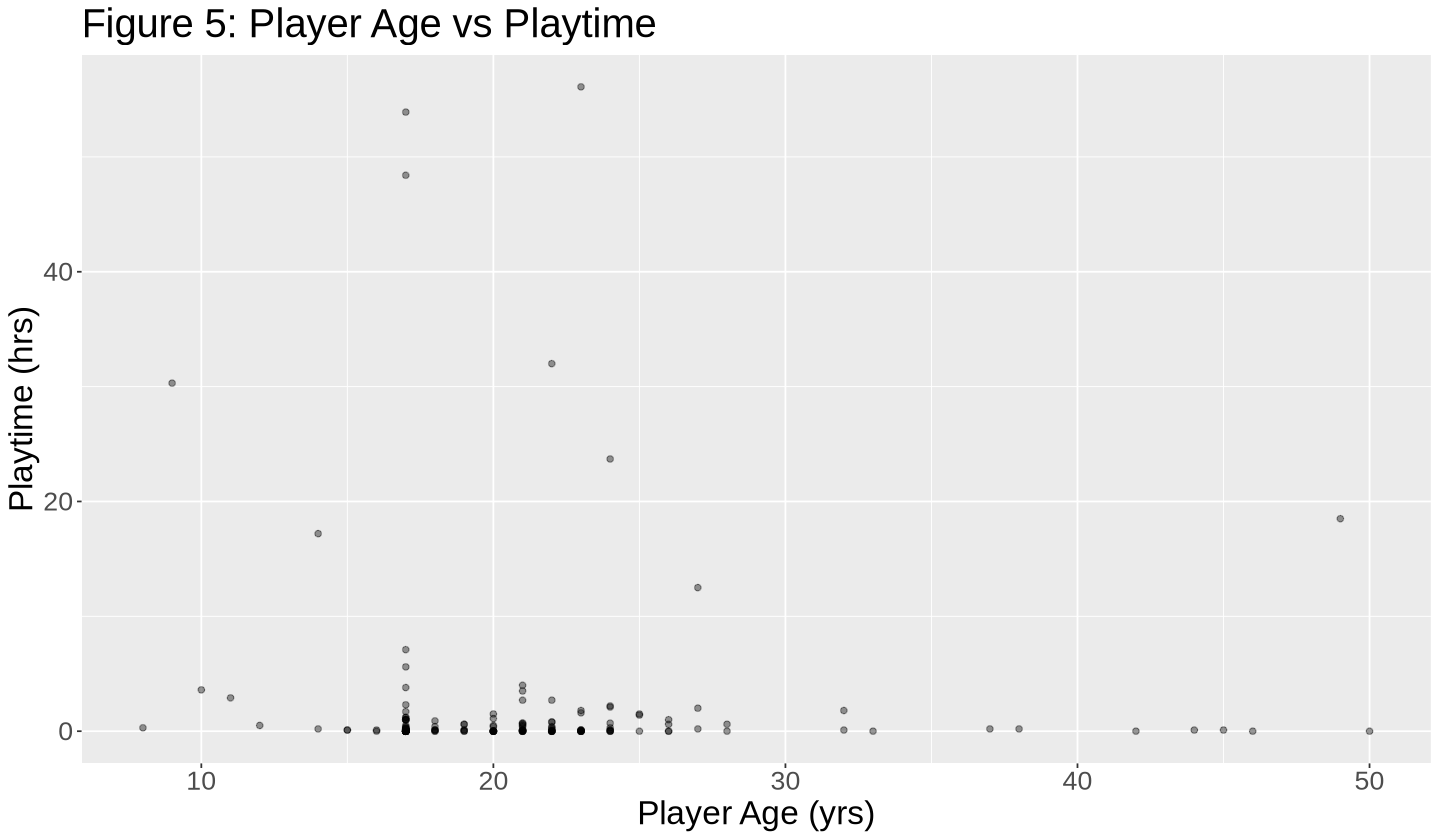

In [8]:
options(repr.plot.width=12, repr.plot.height=7)
player_plot<-wrangled_data|>
    ggplot(aes(x=Age, y=played_hours))+
        geom_point(alpha=0.4)+
        labs(x="Player Age (yrs)", y="Playtime (hrs)", title="Figure 5: Player Age vs Playtime")+
        theme(text=element_text(size=20))
player_plot

Figure 6: Experience Level and Played Hours

Across all experience levels most players still have less than 4 hours of playtime and most high playtime players appear to be in the amateur level. 

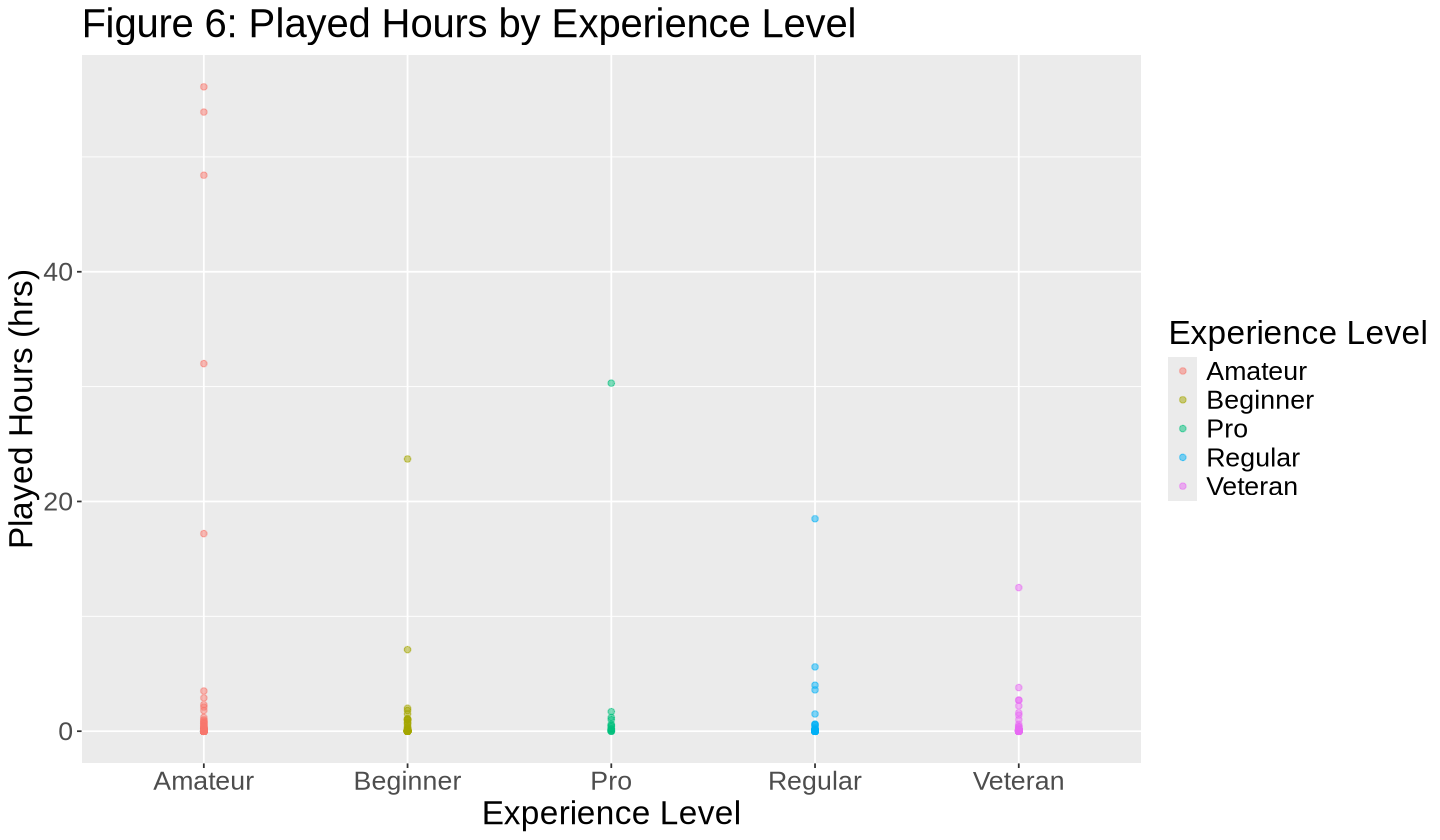

In [9]:
hours_vs_experience<-ggplot(wrangled_data, aes(x=experience, y=played_hours, color=experience))+
    geom_point(alpha=0.5)+
    labs(title="Figure 6: Played Hours by Experience Level", x="Experience Level", y="Played Hours (hrs)", color="Experience Level")+
    theme(text=element_text(size=20))
hours_vs_experience

<h3> Predictive Modeling </h3>

(A set.seed is included for reproducibility)
A regression model was created using k-Nearest Neighbors (kNN) to predict played_hours based on experience_numeric and Age.

The wrangled data is first split into an 80 percent training and 20 percent testing set to later evaluate the model. As knn regression is the chosen model type, the training set is split into 5 for 5 folded cross validation to choose k. 

In [10]:
set.seed(1234)

initial_split<-initial_split(wrangled_data, prop=0.8, strata=played_hours)
player_training<-training(initial_split)
player_testing<-testing(initial_split)

player_vfold<-vfold_cv(player_training, v=5, strata=played_hours)

For cross validation to choose k, k values are tested from 1 to 100  based on the predictors of experience and age, both standardized for equal contribution to the distance calcualtion. The resulting model returns a k value with the lowed rmse of 79. 

In [11]:
kvals<-tibble(neighbors=seq(from=1, to=100, by=1))
player_recipe<-recipe(played_hours~experience_numeric+Age, data=player_training)|>
    step_scale(all_predictors())|>
    step_center(all_predictors())

player_spec<-nearest_neighbor(weight_func="rectangular", neighbors=tune())|>
    set_engine("kknn")|>
    set_mode("regression")

player_tune<-workflow()|>
    add_recipe(player_recipe)|>
    add_model(player_spec)|>
    tune_grid(resamples=player_vfold, grid=kvals)|>
    collect_metrics()|>
    filter(.metric=="rmse")|>
    select(neighbors, mean)
          
lowest_rmse_k<-slice_min(player_tune, mean)
lowest_rmse_k

neighbors,mean
<dbl>,<dbl>
79,6.101982


This graph shows that RMSE decreases as k increases, plateauing around 80 neighbors. The best-performing model had:
- k = 80
- RMSE = 6.11

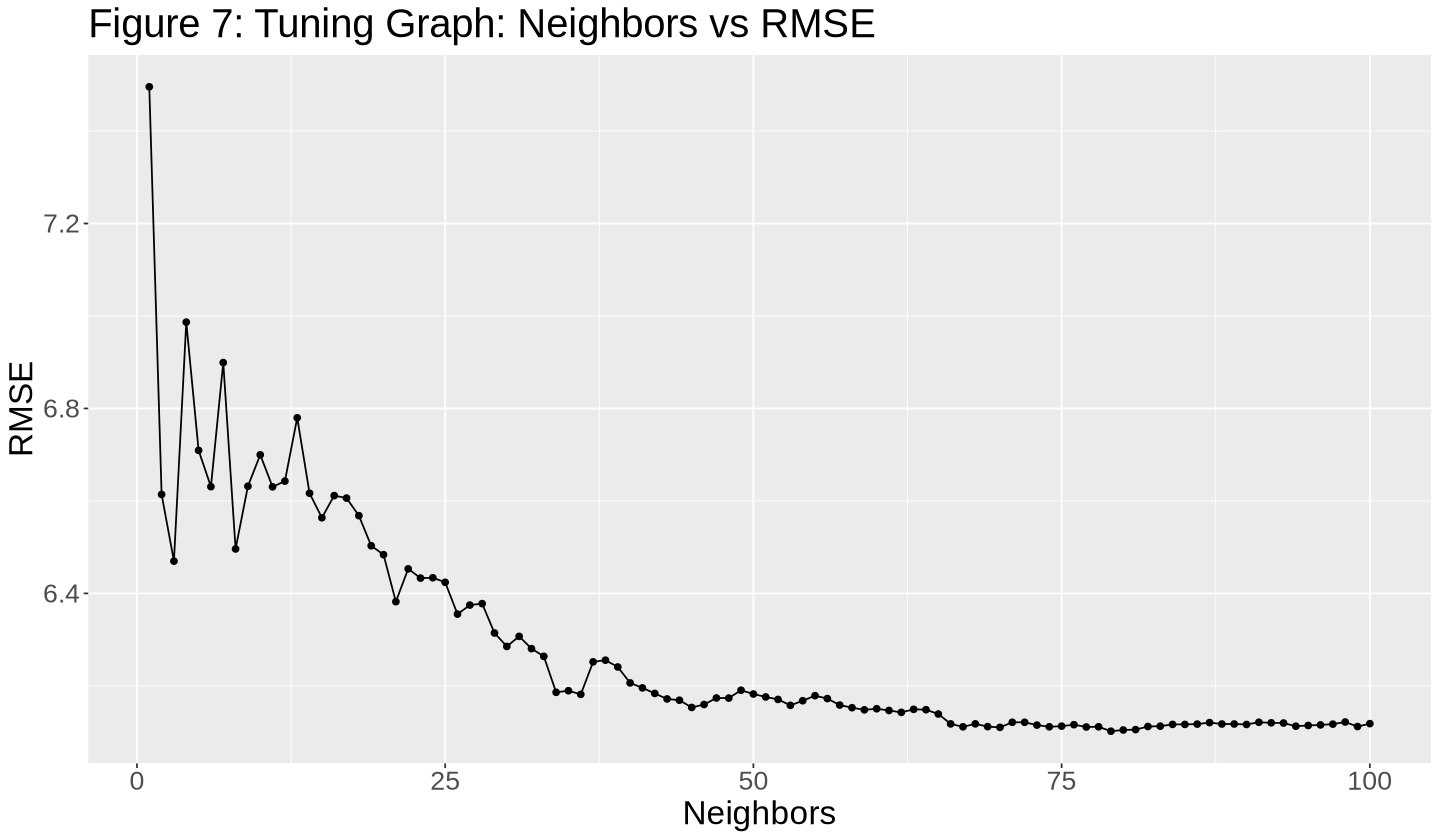

In [12]:
tune_graph<-player_tune|>
    ggplot(aes(x=neighbors, y=mean))+
        geom_point()+
        geom_line()+
        labs(x="Neighbors", y="RMSE", title="Figure 7: Tuning Graph: Neighbors vs RMSE")+
        theme(text=element_text(size=20))
tune_graph

Creating a new spec with the chosen k of 79 and reusing the same recipe with the same predictors, it is tested on the testing set reserved from the first step returning an RMSPE value of 9.82. 

In [13]:
player_spec_tuned<-nearest_neighbor(weight_func="rectangular", neighbors=79)|>
    set_engine("kknn")|>
    set_mode("regression")

player_fit<-workflow()|>
    add_recipe(player_recipe)|>
    add_model(player_spec_tuned)|>
    fit(data=player_training)

player_predictions<-player_fit|>
    predict(player_testing)|>
    bind_cols(player_testing)|>
    metrics(truth=played_hours, estimate=.pred)|>
    filter(.metric=="rmse")
player_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.820538


The code below is a control group of always predicting zero to compare the two RMSPE's.

In [14]:
always_predict_zero_rmspe<-tibble(prediction=rep(0, times=39))|>
    bind_cols(player_testing)|>
    metrics(truth=played_hours, estimate=prediction)|>
    filter(.metric=="rmse")
always_predict_zero_rmspe

Warning message:
“A correlation computation is required, but `estimate` is constant and has 0
standard deviation, resulting in a divide by 0 error. `NA` will be returned.”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,10.18762


<h1>Discussion</h1>

The tuned model was trained on the training set and evaluated on the test set (20% of the data). It achieved an RMSPE of ~9.80, suggesting limited predictive accuracy.
For comparison, a baseline model predicting zero for all test samples had a significantly worse RMSE of ~10.19. This indicates that our tuned model only marginally outperforms the baseline, suggesting that while some predictive signal exists in the input features, the model's overall accuracy is weak. 

The goal of this project was to determine whether player characteristics, specifically experience level, gender, and age, can predict how much time players spend on a Minecraft server, as measured by played_hours. After cleaning and preparing the data, we trained a k-Nearest Neighbors (kNN) regression model using experience and age as predictors.
Through hyperparameter tuning, the optimal number of neighbors was found to be k = 80, resulting in a root mean squared prediction error (RMSPE) of 9.80. While this slightly outperforms a baseline model that predicted zero hours (RMSE ~ 10.19) the performance difference is insignificant. Thus suggesting that while experience and age may contain some relevant information about playtime behaviour these predictors are not strong enough alone. 

<h4>Why Gender Was Excluded</h4>

Although gender data was available, we made the decision not to include gender as a predictor in the final model. This was a deliberate ethical choice: while gender might correlate with engagement in some contexts, using it in a predictive model could reinforce stereotypes or lead to biased targeting strategies. Additionally, the gender variable in this dataset included a diverse and inclusive set of identities, and reducing these to numeric values for modeling risked oversimplifying a complex social characteristic. Therefore, we chose to focus on more behaviorally relevant and ethically neutral features, experience and age, in our analysis.

<h4>Was this expected?</h4>

To some degree, yes. It was reasonable to hypothesize that more experienced players or older individuals might engage with the server more frequently. The results support this to an extent, but the relatively high RMSE indicates that these two variables do not fully explain player engagement. This suggests that other unmeasured factors, such as free time, interest in the game, social connections, or in-game events, likely influence how long players remain active. The other factor that might be influencing a high RMSE is the large number of played_hours values logged as zero; therefore, specifying the prediction of players with played_hours greater than zero could provide a more accurate model. 
Impact of the Findings
The insights gained from this analysis can inform recruitment and retention strategies on multiplayer servers. For example, initiatives aimed at experienced players or specific age groups may yield higher engagement. However, the model's limitations also highlight that demographic and experience based features alone are insufficient, and more dynamic or behaviorally rich data may be needed for stronger predictions.

<h4>Future Questions</h4>

This project raises several questions worth exploring:
- Would including in game activity data (achievements and chat frequency) improve predictive power?
- Could a classification approach (predicting whether a player will exceed a certain number of hours) offer more valuable insights?
- How do social interactions and dynamics on the server ( presence of friends or teammates) affect playtime?
- By eliminating the players who do not log any hours (filtering out played_hours equal to zero), would the predictive power improve?
